<a href="https://colab.research.google.com/github/saadsaffar/seoul-Bike-sharing-demand-prediction/blob/main/CP_2_Seoul_Bike_Sharing_Demand_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Seoul Bike Sharing Demand Prediction </u></b>

## <b> Problem Description </b>

### Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and accessible to the public at the right time as it lessens the waiting time. Eventually, providing the city with a stable supply of rental bikes becomes a major concern. The crucial part is the prediction of bike count required at each hour for the stable supply of rental bikes.


## <b> Data Description </b>

### <b> The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information.</b>


### <b>Attribute Information: </b>

* ### Date : year-month-day
* ### Rented Bike count - Count of bikes rented at each hour
* ### Hour - Hour of he day
* ### Temperature-Temperature in Celsius
* ### Humidity - %
* ### Windspeed - m/s
* ### Visibility - 10m
* ### Dew point temperature - Celsius
* ### Solar radiation - MJ/m2
* ### Rainfall - mm
* ### Snowfall - cm
* ### Seasons - Winter, Spring, Summer, Autumn
* ### Holiday - Holiday/No holiday
* ### Functional Day - NoFunc(Non Functional Hours), Fun(Functional hours)

# Loading Dataset and Importing Modules

In [ ]:
# importing the modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 
from statsmodels.stats.outliers_influence import variance_inflation_factor


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBClassifier

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import log_loss

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
font = {'family' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

## Mount the drive and import the datset

In [ ]:
# Mount your drive and read the csv file. Make sure you are using the correct file path
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# loading csv File
file_path = '/content/drive/MyDrive/AlmaBetter/Cohort Hardeol/Capstone Projects/Project 2/Bike Sharing Demand Prediction/SeoulBikeData.csv'
df=pd.read_csv(file_path, encoding='cp1252')

## Common Functions

In [ ]:
# define global variable
model_scores_dict_train = {}
model_scores_dict_test = {}

def regression_line_plot(df, col,dependent_variable):
  fig = plt.figure(figsize=(9, 6))
  ax = fig.gca()
  feature = df[col]
  label = df[dependent_variable]
  correlation = feature.corr(label)
  plt.scatter(x=feature, y=label)
  plt.xlabel(col)
  plt.ylabel(dependent_variable)
  ax.set_title(dependent_variable+' vs '+col+' - correlation: ' + str(correlation))
  z = np.polyfit(df[col], df[dependent_variable], 1)
  y_hat = np.poly1d(z)(df[col])
  plt.plot(df[col], y_hat, "r--", lw=1)

def histogram(df, col):
  fig = plt.figure(figsize=(9, 6))
  ax = fig.gca()
  feature = df[col]
  feature.hist(bins=50, ax = ax)
  ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
  ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
  ax.set_title(col)

def evaluation_metrics(model, X, y, predicted_values ):
  #calculate MSE
  MSE_d= mean_squared_error(y, predicted_values)

  #calculate RMSE
  RMSE_d=np.sqrt(MSE_d)

  #calculate MAE
  MAE_d= mean_absolute_error(y, predicted_values)

  #calculate r2 and adjusted r2
  r2_d= r2_score(y, predicted_values)
  adjusted_r2_linear_reg_train = (1-(1-r2_score(y, predicted_values))*((X.shape[0]-1)/(X.shape[0]-X.shape[1]-1)) )
  return {
      'MSE'         : MSE_d,
      'RMSE'        : RMSE_d,
      'MAE'         : MAE_d,
      'R2'          : r2_d,
      'Adjusted R2' : adjusted_r2_linear_reg_train
  }

def show_evaluation_metrics(score_dict):
  for key, value in score_dict.items():
    print(key,' : ',value)

def save_model_scores(model_name, train_model_score, test_model_score):
  global model_scores_dict_train
  global model_scores_dict_test
  model_score = {}

  model_scores_dict_train[model_name] = train_model_score
  model_scores_dict_test[model_name] = test_model_score

def model_evaluation_show_and_save(model, model_name, X, y_train,y_test, predicted_values_train, predicted_values_test):
  train_score = evaluation_metrics(model, X, y_train, predicted_values_train)
  print('For Train Data: ')
  show_evaluation_metrics(train_score)

  print("-"*40)

  test_score = evaluation_metrics(model, X, y_test, predicted_values_test)
  print('For Test Data: ')
  show_evaluation_metrics(test_score)

  save_model_scores(model_name, train_score, test_score)

def show_model_scores():
  global model_scores_dict_train
  global model_scores_dict_test
  model_scores_dict = {
      'Train': model_scores_dict_train,
      'Test' : model_scores_dict_test
  }
  reformed_dict = {}
  for outerKey, innerDict in model_scores_dict.items():
    for innerKey, values in innerDict.items():
      reformed_dict[(outerKey, innerKey)] = values

  # Display multiindex dataframe
  return pd.DataFrame(reformed_dict)


# Understand More About The Data

##summary of data

In [ ]:
# View top 5 rows of the data
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [ ]:
# View bottom 5 rows of the data
df.tail()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes
8759,30/11/2018,584,23,1.9,43,1.3,1909,-9.3,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [ ]:
# get the shape of the data
shape = df.shape
print(f"There are total {shape[0]} rows and {shape[1]} columns.")

There are total 8760 rows and 14 columns.


In [ ]:
# get all column names
columns = list(df.columns)
columns

['Date',
 'Rented Bike Count',
 'Hour',
 'Temperature(°C)',
 'Humidity(%)',
 'Wind speed (m/s)',
 'Visibility (10m)',
 'Dew point temperature(°C)',
 'Solar Radiation (MJ/m2)',
 'Rainfall(mm)',
 'Snowfall (cm)',
 'Seasons',
 'Holiday',
 'Functioning Day']

In [ ]:
# get details of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [ ]:
# get the description of the numerical data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rented Bike Count,8760.0,704.602055,644.997468,0.0,191.00,504.50,1065.25,3556.00
Hour,8760.0,11.500000,6.922582,0.0,5.75,11.50,17.25,23.00
Temperature(°C),8760.0,12.882922,11.944825,-17.8,3.50,13.70,22.50,39.40
Humidity(%),8760.0,58.226256,20.362413,0.0,42.00,57.00,74.00,98.00
Wind speed (m/s),8760.0,1.724909,1.036300,0.0,0.90,1.50,2.30,7.40
Visibility (10m),8760.0,1436.825799,608.298712,27.0,940.00,1698.00,2000.00,2000.00
Dew point temperature(°C),8760.0,4.073813,13.060369,-30.6,-4.70,5.10,14.80,27.20
Solar Radiation (MJ/m2),8760.0,0.569111,0.868746,0.0,0.00,0.01,0.93,3.52
Rainfall(mm),8760.0,0.148687,1.128193,0.0,0.00,0.00,0.00,35.00
Snowfall (cm),8760.0,0.075068,0.436746,0.0,0.00,0.00,0.00,8.80


In [ ]:
# get the description of the categorical data
df.describe(include="object").T

,count,unique,top,freq
Date,8760,365,01/12/2017,24
Seasons,8760,4,Spring,2208
Holiday,8760,2,No Holiday,8328
Functioning Day,8760,2,Yes,8465


# Preprocessing the dataset

## Missing values

In [ ]:
#check for count of missing values
df.isna().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

* **It can be seen that there are no missing values present in the data.**



## Duplicate values

In [ ]:
print(f"The number of duplicate values in the data is {len(df[df.duplicated()])}")

The number of duplicate values in the data is 0


* **It seems that there are no duplicate rows present in the data.**

## Changing column name

* **The column names of the dataset are complicated. So we will make it simpler.**.

In [ ]:
# Rename the columns
df.rename(columns = lambda x: x.partition('(')[0].strip(), inplace=True)
list(df.columns)

['Date',
 'Rented Bike Count',
 'Hour',
 'Temperature',
 'Humidity',
 'Wind speed',
 'Visibility',
 'Dew point temperature',
 'Solar Radiation',
 'Rainfall',
 'Snowfall',
 'Seasons',
 'Holiday',
 'Functioning Day']

# Exploratory Data Analysis Of The Data Set

## Analysis of Dependent Variable:

* **In the dataset  "Rented Bike Count"  is the dependent variable. Let's analyze it.**

In [ ]:
dependent_variable = "Rented Bike Count"

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


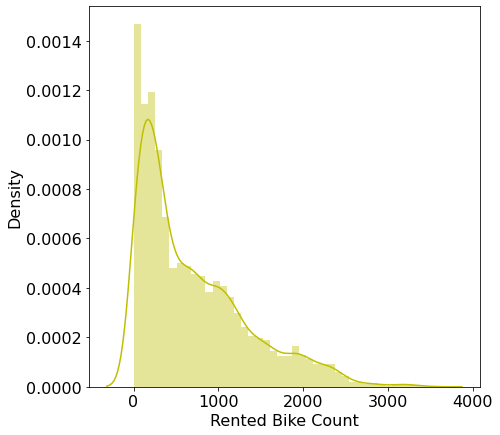

In [ ]:
# Let's create a histogram 
plt.figure(figsize=(7,7))
sns.distplot(df[dependent_variable],color="y")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


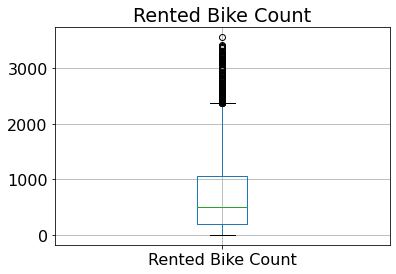

In [ ]:
# Let's create a box plot to check outliers
df.boxplot(column=dependent_variable)
plt.title(dependent_variable)
plt.show()

* **From the box plot, we can see  many outliers present in the data.**
* **From the histogram, it is clear that the spread of the data is positively skewed. So, we will use transformation techniques to normalize the data.**

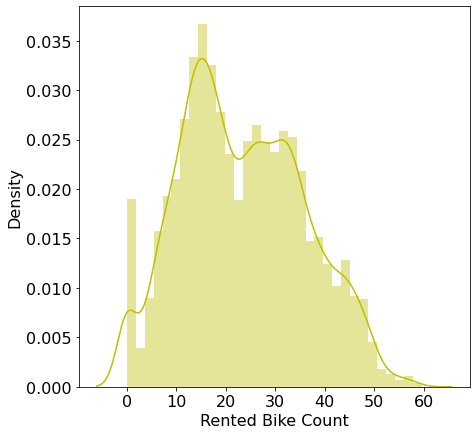

In [ ]:
# Let's use square root technique to normalize the data
plt.figure(figsize=(7,7))
df['Rented Bike Count'] = df['Rented Bike Count'].apply(lambda x: math.sqrt(x))
sns.distplot(df['Rented Bike Count'],color="y")

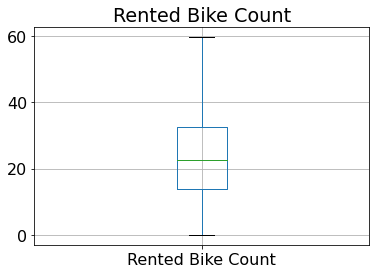

In [ ]:
df.boxplot(column=dependent_variable)
plt.title(dependent_variable)
plt.show()

* **After using square root on 'Reneted Bike Count', it is seen that there are no more outliers present.**

## Analysis of categorical variables

**Let's look at each categorical variable one by one**

### Date

In [ ]:
# Let's make date object to datetime
from datetime import datetime
format = '%d/%m/%Y'
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x,format))

In [ ]:
print(f"Total unique values in the Date column is {len(df.Date.unique())}")

Total unique values in the Date column is 365


In [ ]:
print(f"The minimum date is {df['Date'].min().date()} and maximum date is {df['Date'].max().date()}")

The minimum date is 2017-12-01 and maximum date is 2018-11-30


* **It can be seen that there are 365 days and for each day there are 24 entries (each hour) totalling 8760 i.e. total no. of rows. But we can't get any valuable information for each day, so instead, we can create another feature that contains a month. Since the starting date is 01/12/2017 and the end date is 30/11/2018, we can neglect the year.**

#### Month

In [ ]:
# Ceate a new feature month from date
df['month'] = pd.DatetimeIndex(df['Date']).month
df.head()

,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day,month
0,2017-12-01,15.937377,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12
1,2017-12-01,14.282857,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12
2,2017-12-01,13.152946,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,12
3,2017-12-01,10.344080,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12
4,2017-12-01,8.831761,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12


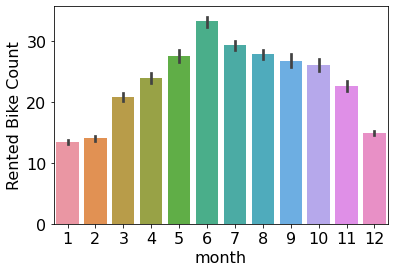

In [ ]:
# plot a barplot month vs Rented Bike Count
sns.barplot(x = "month",y = dependent_variable,data = df)

* **It seems that in June rental bike count is highest.**

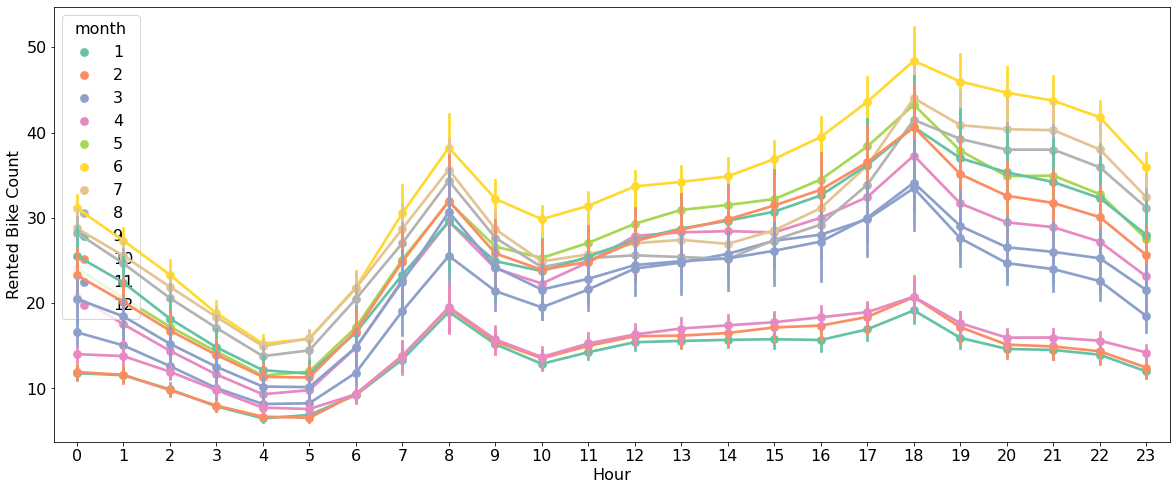

In [ ]:
# Rented Bike Count against Hour for weekdays
fig,ax=plt.subplots(figsize=(20,8))
sns.pointplot(x = "Hour",y = dependent_variable, hue="month",data = df, palette="Set2")

* It seems that for the months from December to February (winter season) the bike is lower than the other months.

#### WeekDay

In [ ]:
# create weekday variable
df['WeekDay']=df["Date"].dt.day_name() 

In [ ]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
week_day_wise_bike_count=pd.DataFrame(df.groupby('WeekDay').sum()['Rented Bike Count']).reindex(cats)
week_day_wise_bike_count.style.background_gradient(cmap=sns.light_palette("red", as_cmap=True))

,Rented Bike Count
WeekDay,
Monday,30038.871795
Tuesday,28432.582187
Wednesday,29989.299923
Thursday,28865.309104
Friday,30958.302920
Saturday,29749.618212
Sunday,27330.152056


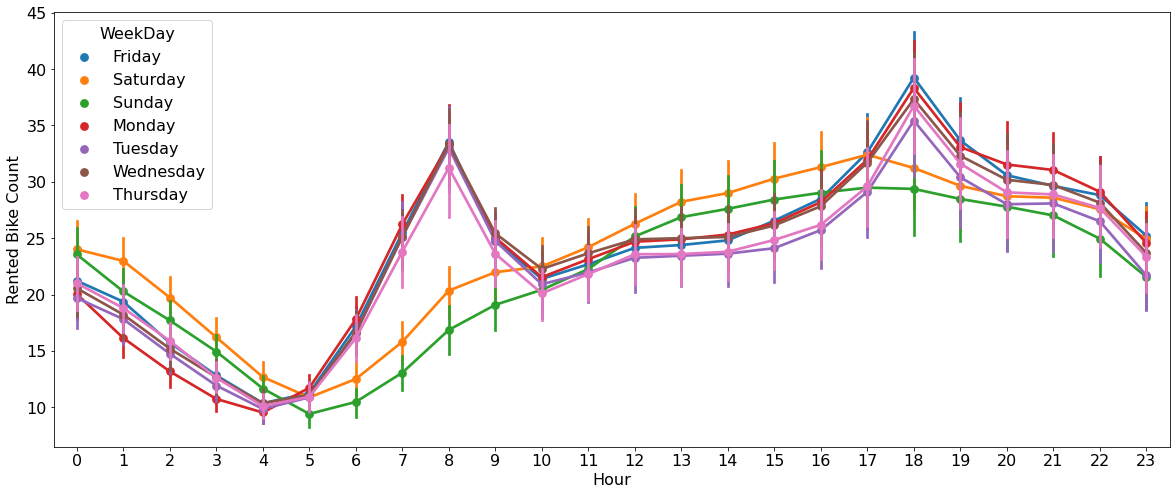

In [ ]:
# Rented Bike Count against Hour for weekdays
fig,ax=plt.subplots(figsize=(20,8))
sns.pointplot(x = "Hour",y = dependent_variable, hue="WeekDay",data = df)

* **From the above plot, we can see that there is a different trend for Saturday & Sunday compared to others.**
* **So we can create a new categorical feature where we consider Saturday & Sunday as a weekend.**

#### isWeekend

In [ ]:
# create isWeekend variable
df['isWeekend'] = df['WeekDay'].apply(lambda x: 1 if x == 'Saturday' or x == 'Sunday' else 0)

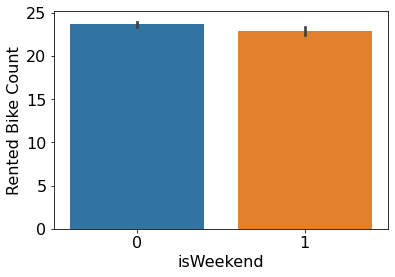

In [ ]:
# plot a barplot isWeekend vs Rented Bike Count
sns.barplot(x = "isWeekend",y = dependent_variable,data = df)

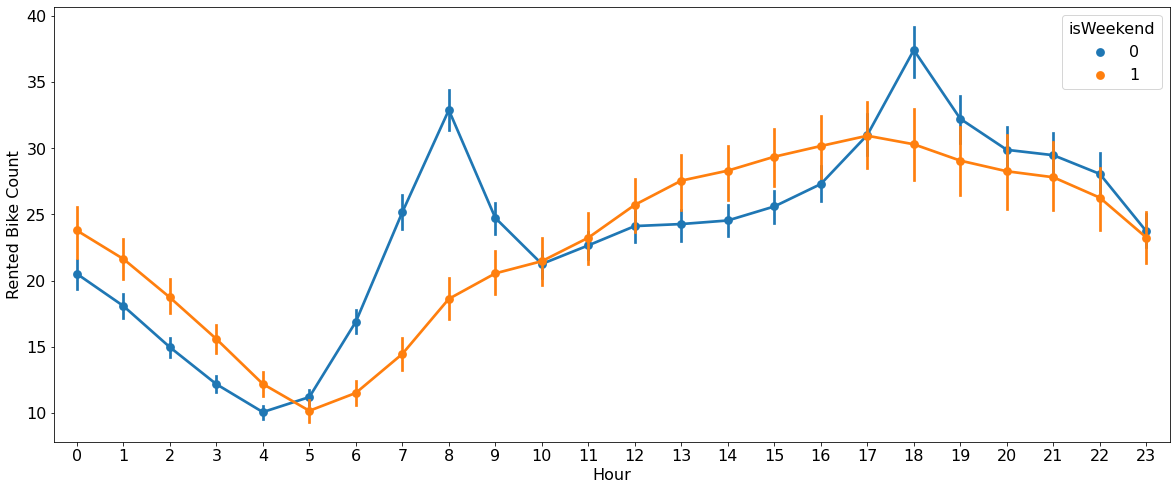

In [ ]:
# Rented Bike Count against Hour for isWeekend
fig,ax=plt.subplots(figsize=(20,8))
sns.pointplot(x = "Hour",y = dependent_variable, hue="isWeekend",data = df)

* **Since we see a trend, we will remove WeekDay.**

In [ ]:
# dropping 'WeekDay'
df.drop(['WeekDay'], axis=1, inplace = True)

In [ ]:
# checking if 'WeekDay' dropped
assert 'WeekDay' not in df.columns

* **Now we will remove 'Date' feature.**

In [ ]:
# dropping 'Date'
df.drop(['Date'], axis=1, inplace = True)

In [ ]:
# checking if 'Date' dropped
assert 'Date' not in df.columns

### Seasons

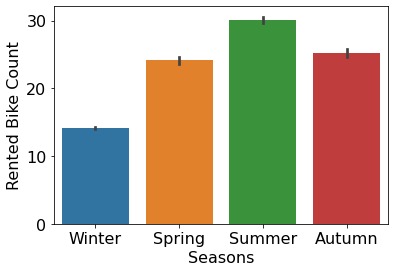

In [ ]:
# plot a barplot season vs Rented Bike Count
#fig,ax=plt.subplots(figsize=(20,8))
sns.barplot(x = "Seasons",y = dependent_variable,data = df)

* **Let's check the trend for seasonwise bike count for each hour.**

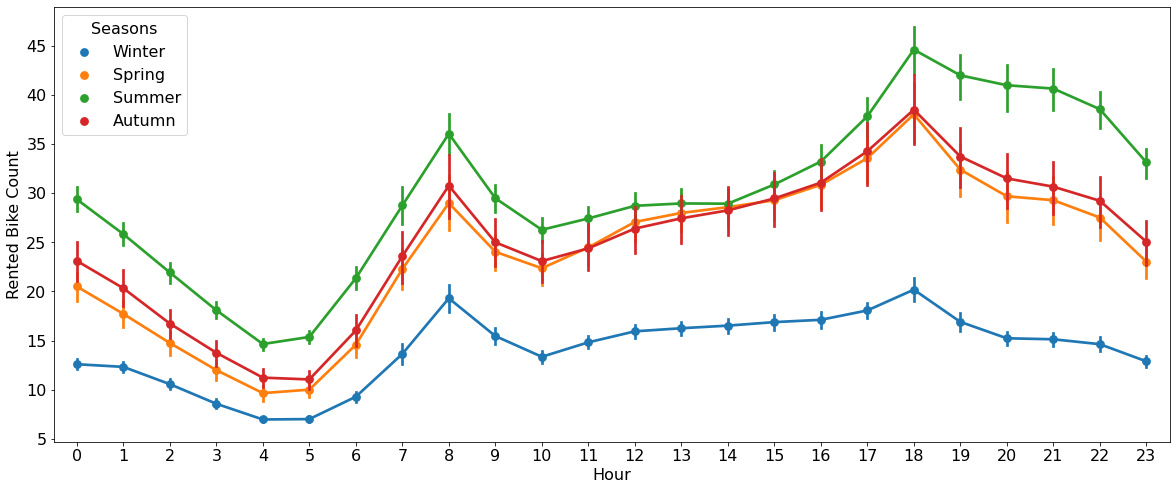

In [ ]:
# Rented Bike Count against Hour for each seasons
fig,ax=plt.subplots(figsize=(20,8))
sns.pointplot(x = "Hour",y = dependent_variable, hue="Seasons",data = df)

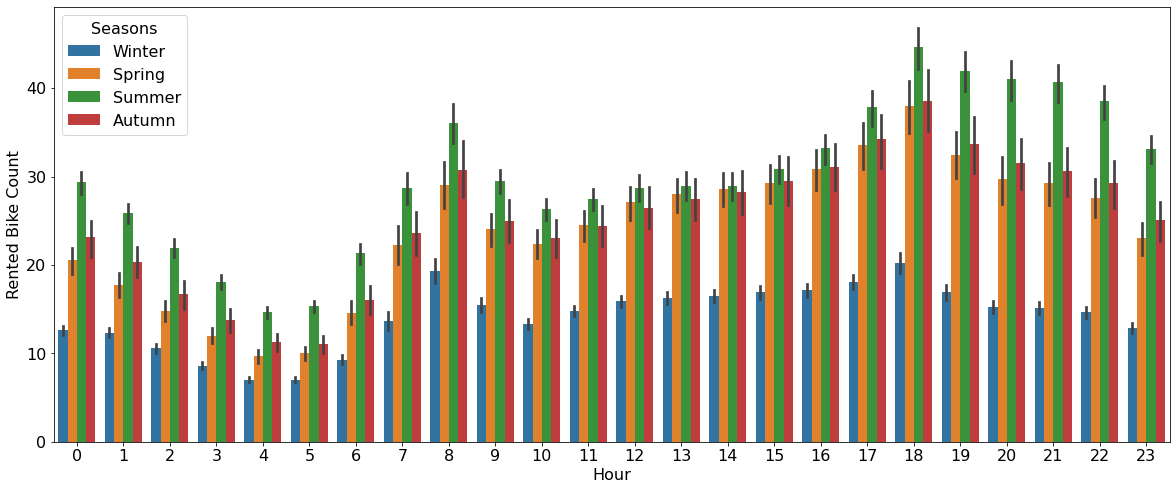

In [ ]:
# Rented Bike Count against Hour for each season 
fig,ax=plt.subplots(figsize=(20,8))
sns.barplot(x = "Hour",y = dependent_variable, hue="Seasons",data = df)

**From the above plot, we can conclude that**
*   **For winter bike count is the lowest.**
*   **For summer bike count is the highest.**



### Holiday

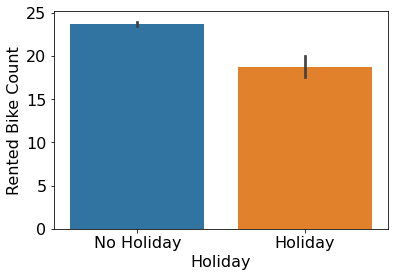

In [ ]:
# plot a barplot Holiday vs Rented Bike Count
sns.barplot(x = "Holiday",y = dependent_variable,data = df)

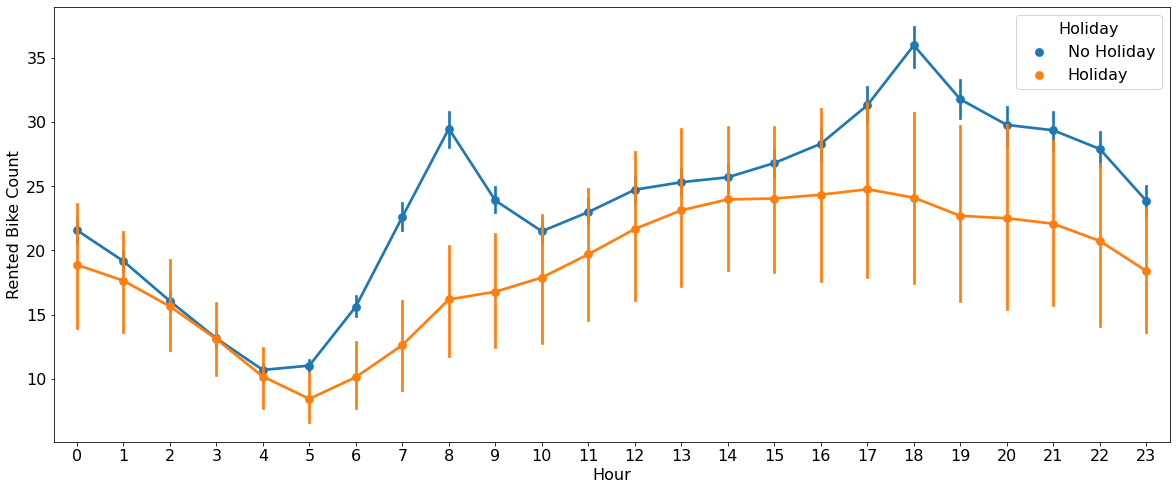

In [ ]:
fig,ax=plt.subplots(figsize=(20,8))
sns.pointplot(x = "Hour",y = dependent_variable, hue="Holiday",data = df)

* **From the above plot, we can see that the rented bike count is lower on holidays compared to the working day.**
* **On working days from 7-9 AM and 5-7 PM, there is a sudden spike.** 

### Functioning Day

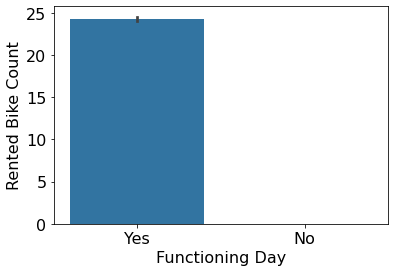

In [ ]:
# plot a barplot Functioning Day vs Rented Bike Count
sns.barplot(x = "Functioning Day",y = dependent_variable,data = df)

In [ ]:
non_functioning_day_df = df[df['Functioning Day'] == "No"]
mean_bike_count = non_functioning_day_df[dependent_variable].mean()
print(f"Mean value of bike count for non functioning day(hour) is {mean_bike_count}")
print(f"Total rows with non functioning day(hour) is {len(non_functioning_day_df)}")

Mean value of bike count for non functioning day(hour) is 0.0
Total rows with non functioning day(hour) is 295


*   **It can be seen that for non functioning day(hour) the bike count is 0. It means for that hour the service is discontinued which is why the total rented bike count is 0. So, we can remove the rows in which the value is "No" and since the remaining data points have the same value (i.e. "Yes") we choose to drop the "Functioning Day" column.**

In [ ]:
# save previous rows
previous_rows = df.shape[0]

In [ ]:
# removing the rows of "Functioning Day" with "No" values
df.drop(df[df['Functioning Day'] == 'No'].index, inplace = True)
print(f"Rows before deletion is {previous_rows} and after deletion is {df.shape[0]}")

Rows before deletion is 8760 and after deletion is 8465


In [ ]:
# Let's drop the column Functioning Day
df.drop(['Functioning Day'], axis=1, inplace = True)

In [ ]:
# checking if dropping of the column 'Functioning Day' is successful
assert 'Functioning Day' not in df.columns

## Analysis of Numerical variables

### Hour

[Text(0.5, 1.0, 'Rented bikes counts acording to Hour')]

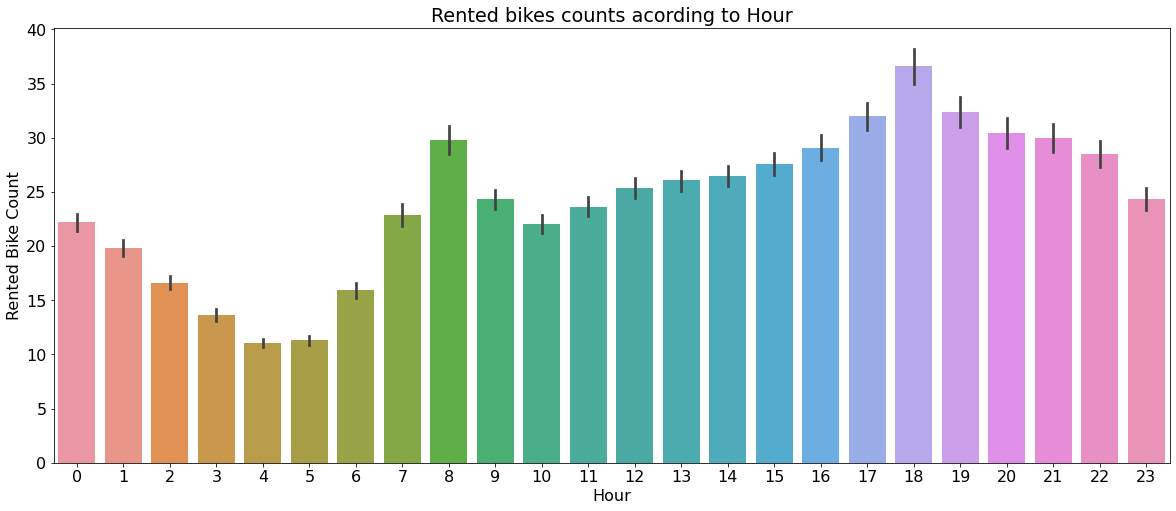

In [ ]:
# bar plot for 'Hour'
fig,ax=plt.subplots(figsize=(20,8))
sns.barplot(data=df,x='Hour',y=dependent_variable)
ax.set(title='Rented bikes counts acording to Hour')

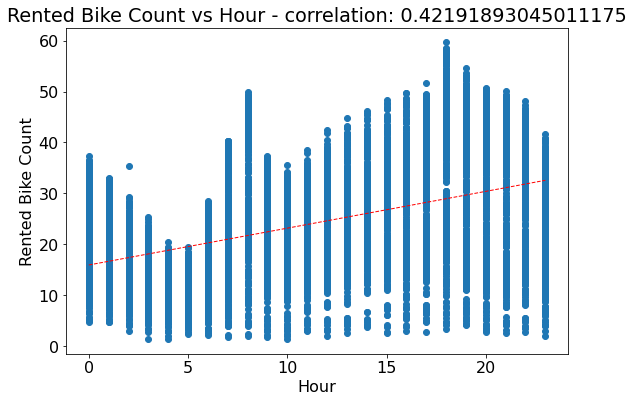

In [ ]:
# find the correlation of Hour with the dependent variable
col = "Hour"
regression_line_plot(df, col, dependent_variable)

* **There is a correlation between 'Hour' and 'Rented bike count'.**
* **7-9 AM and 5-7 PM, there is a sudden spike in bike count. So we can create a new categorical feature where we take 7 AM to 7 PM as a working hour.**

#### isWorkingHour

In [ ]:
df['isWorkingHour']=df['Hour'].apply(lambda x : 0 if (x >19 or x<8) else 1)

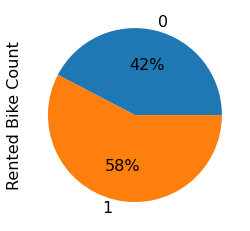

In [ ]:
df.groupby('isWorkingHour').sum()['Rented Bike Count'].plot.pie(autopct='%.0f%%')

* **During working hours (i.e. 7 AM to 7 PM) rented bike count is high (i.e. 58%) compared to not working hours (i.e. 42%).**

### Temperature

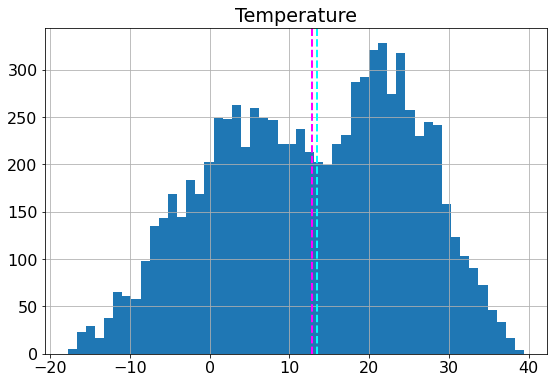

In [ ]:
# check the distribution of the column Temperature
col = "Temperature"
histogram(df, col)

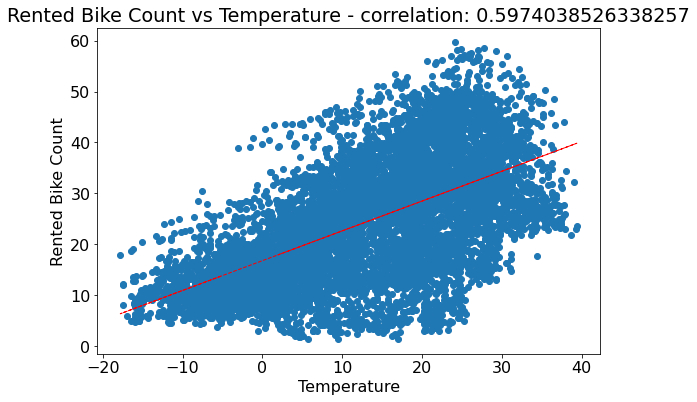

In [ ]:
# find the correlation of Temperature with the dependent variable
regression_line_plot(df, col, dependent_variable)

* **From the above plot, we can see a linear trend between Temperature vs Rented bike count**

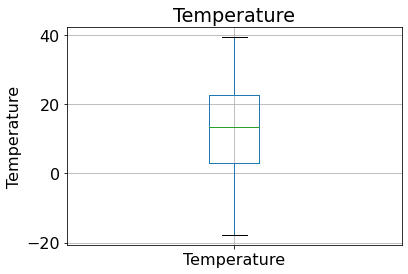

In [ ]:
# Check the outliers
df.boxplot(column=col)
plt.ylabel(col)
plt.title(col)
plt.show()

* **There is no outlier present in the data.**

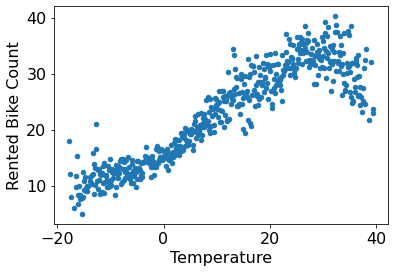

In [ ]:
df2 = df.groupby(col, as_index=False).agg({dependent_variable:'mean'})
df2.plot.scatter(x=col, y=dependent_variable)

* **It seems that between 20-30 °C rented bike count increases.**

### Humidity

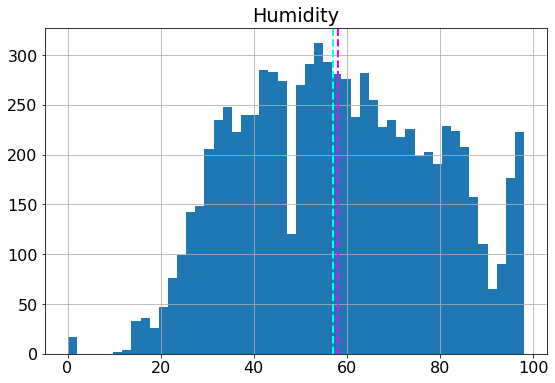

In [ ]:
# check the distribution of the column Humidity
col = "Humidity"
histogram(df, col)

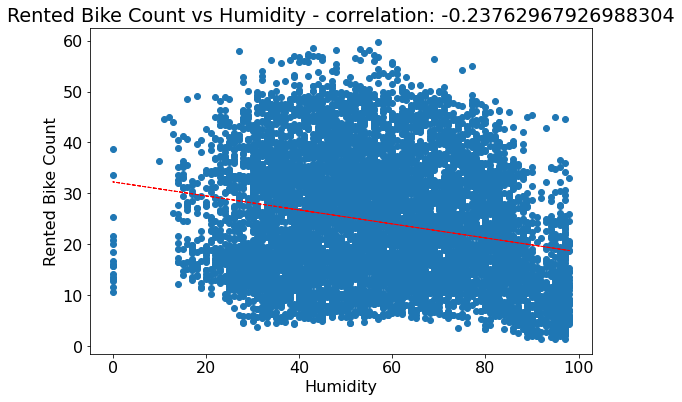

In [ ]:
# find the correlation of Humidity with the dependent variable
regression_line_plot(df, col, dependent_variable)

* **There is a slight negative linear relation between Humidity vs Rented bike count.**

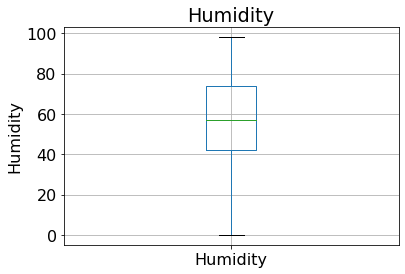

In [ ]:
# Check the outliers
df.boxplot(column=col)
plt.ylabel(col)
plt.title(col)
plt.show()

* **There are no outliers for Humidity.**

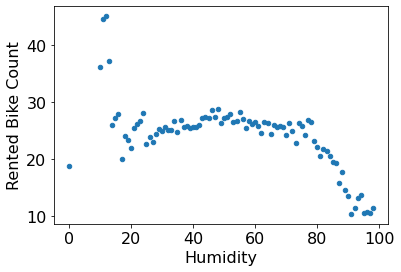

In [ ]:
df2 = df.groupby(col, as_index=False).agg({dependent_variable:'mean'})
df2.plot.scatter(x=col, y=dependent_variable)

### Wind speed

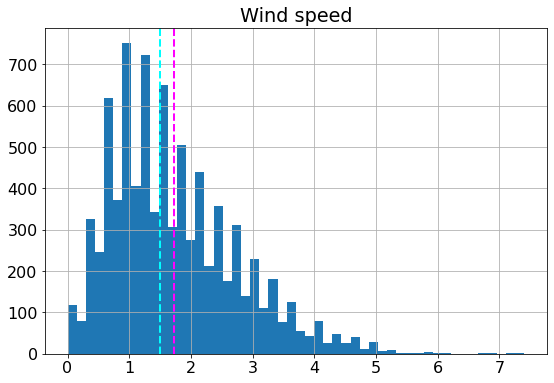

In [ ]:
# check the distribution of the column Wind speed
col = "Wind speed"
histogram(df,col)

* **From the above plot, we can see that Wind speed is positively skewed. We can use the Square root technique to make it normally distributed.**

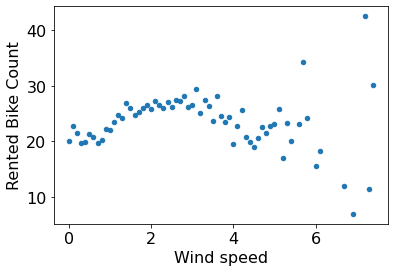

In [ ]:
df2 = df.groupby(col, as_index=False).agg({dependent_variable:'mean'})
df2.plot.scatter(x=col, y=dependent_variable)

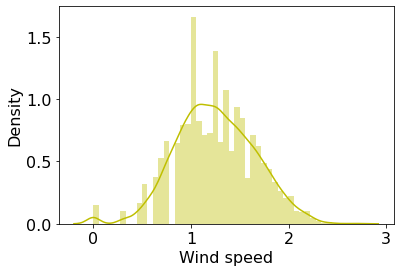

In [ ]:
# Square root to make it normally distributed
df['Wind speed'] = df['Wind speed'].apply(lambda x: math.sqrt(x))
sns.distplot(df['Wind speed'],color="y")

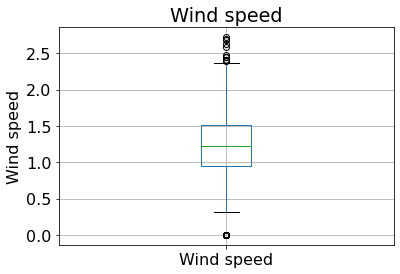

In [ ]:
# Check the outliers
df.boxplot(column=col)
plt.ylabel(col)
plt.title(col)
plt.show()

* **There are outliers present in the 'Wind speed' column.**

In [ ]:
# perform a robust scaler transform of the column 'Wind speed'
robust_scalar = RobustScaler()
wind_speed = robust_scalar.fit_transform(df[['Wind speed']])

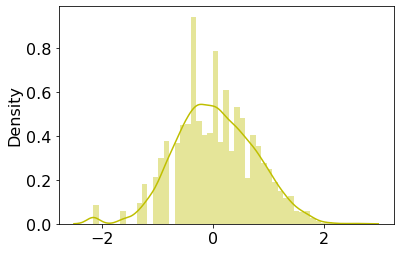

In [ ]:
sns.distplot(wind_speed,color="y")

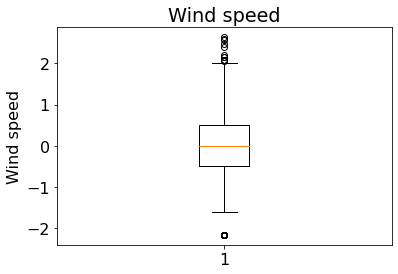

In [ ]:
plt.boxplot(wind_speed)
plt.ylabel(col)
plt.title(col)
plt.show()

### Visibility

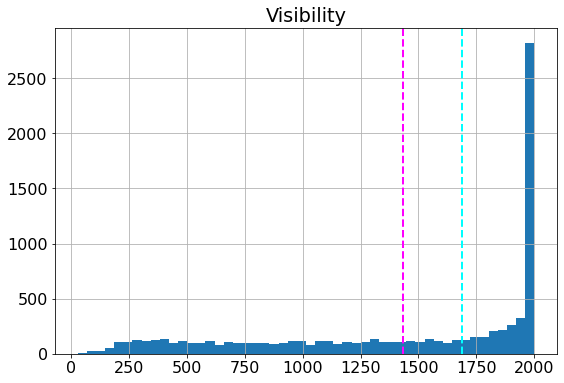

In [ ]:
# check the distribution of the column Humidity
col = "Visibility"
histogram(df,col)

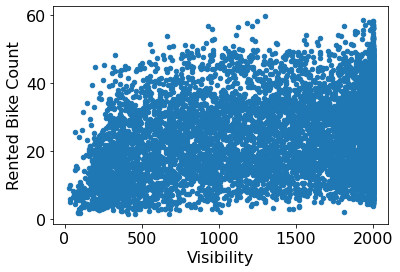

In [ ]:
df.plot.scatter(x=col, y=dependent_variable)

### Dew point temperature

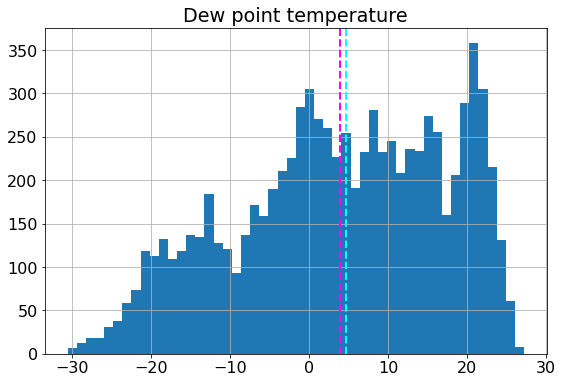

In [ ]:
# check the distribution of the column Dew point temperature
col = "Dew point temperature"
histogram(df, col)

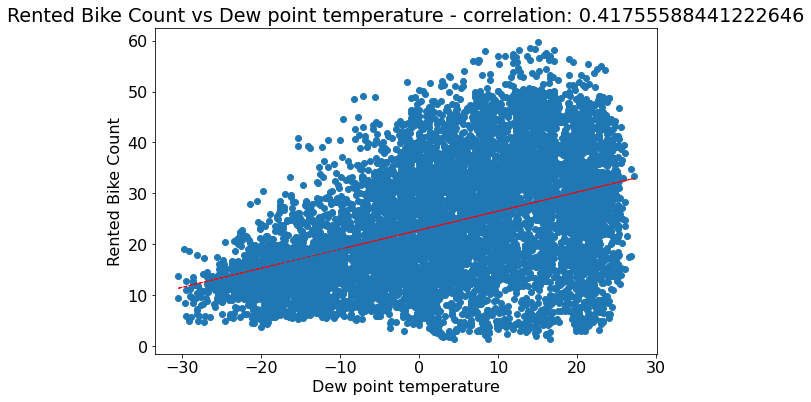

In [ ]:
# find the correlation of Dew point temperature with the dependent variable
regression_line_plot(df, col, dependent_variable)

* **From the above plot, we can see a linear trend between Dew point temperature vs Rented bike count**

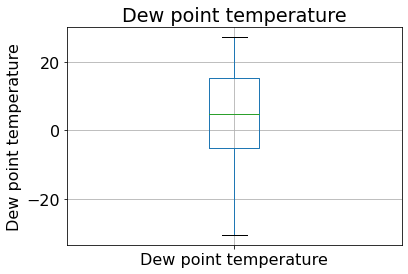

In [ ]:
# Check the outliers
df.boxplot(column=col)
plt.ylabel(col)
plt.title(col)
plt.show()

* **There are no outliers present in the data.**

### Solar Radiation

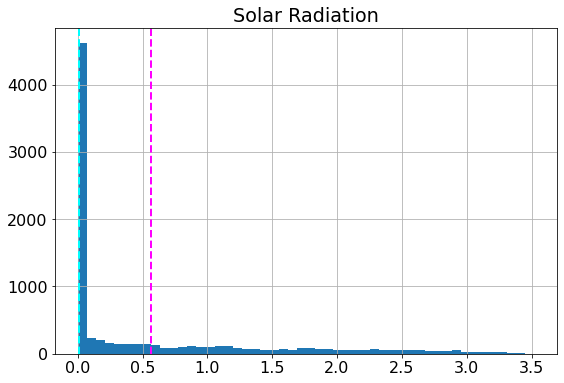

In [ ]:
# check the distribution of the column Solar Radiation
col = "Solar Radiation"
histogram(df, col)

In [ ]:
print(f"{col} at 0 is {round(len(df[df[col] == 0])/df.shape[0]*100,2)}%")

Solar Radiation at 0 is 49.04%


In [ ]:
df[col].describe()

count    8465.000000
mean        0.567868
std         0.868245
min         0.000000
25%         0.000000
50%         0.010000
75%         0.930000
max         3.520000
Name: Solar Radiation, dtype: float64

### Rainfall

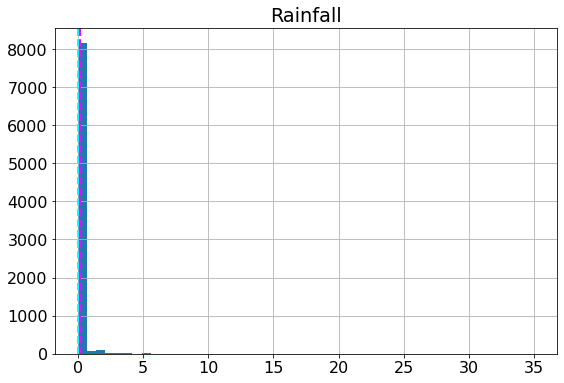

In [ ]:
# check the distribution of the column Rainfall
col = "Rainfall"
histogram(df, col)

In [ ]:
print(f"No {col} (i.e 0) is {round(len(df[df[col] == 0])/df.shape[0]*100,2)}%")

No Rainfall (i.e 0) is 93.9%


### Snowfall

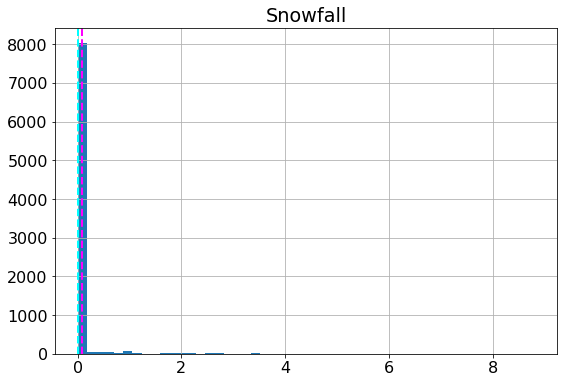

In [ ]:
# check the distribution of the column Snowfall
col = "Snowfall"
histogram(df, col)

In [ ]:
print(f"No {col} (i.e 0) is {round(len(df[df[col] == 0])/df.shape[0]*100,2)}%")

No Snowfall (i.e 0) is 94.77%


## Encoding

* **There are 2 categorical features Holiday & Seasons which are needed to be encoded.**

In [ ]:
encoders_nums = {
    "Seasons":{"Spring":0,"Summer":1, "Autumn": 2, "Winter":3},
    "Holiday": {'Holiday':1, "No Holiday":0}
    }

df = df.replace(encoders_nums)

In [ ]:
df.head()

,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,month,isWeekend,isWorkingHour
0,15.937377,0,-5.2,37,1.483240,2000,-17.6,0.0,0.0,0.0,3,0,12,0,0
1,14.282857,1,-5.5,38,0.894427,2000,-17.6,0.0,0.0,0.0,3,0,12,0,0
2,13.152946,2,-6.0,39,1.000000,2000,-17.7,0.0,0.0,0.0,3,0,12,0,0
3,10.344080,3,-6.2,40,0.948683,2000,-17.6,0.0,0.0,0.0,3,0,12,0,0
4,8.831761,4,-6.0,36,1.516575,2000,-18.6,0.0,0.0,0.0,3,0,12,0,0


## Feature Selection

### Correlation

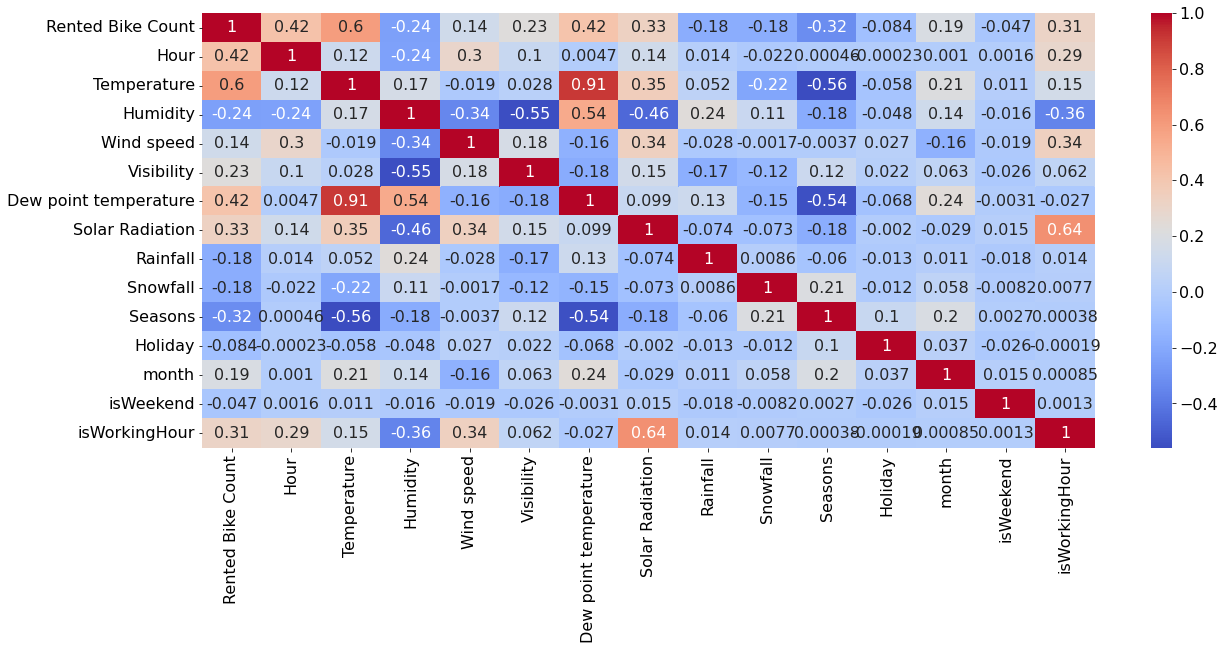

In [ ]:
plt.figure(figsize=(20,8))
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')

**From the heatmap**
* **Temperature & Dew point temperature is strongly correlated. So, even if we drop any one of them, it will not affect the data. We drop Dew point temperature.**

In [ ]:
df.drop(['Dew point temperature'], axis=1, inplace = True)

In [ ]:
# check if 'Dew point temperature' is successfully dropped
assert 'Dew point temperature' not in df.columns

### Variance Inflation Factor (VIF)

In [ ]:
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [ ]:
list(df.columns)

['Rented Bike Count',
 'Hour',
 'Temperature',
 'Humidity',
 'Wind speed',
 'Visibility',
 'Solar Radiation',
 'Rainfall',
 'Snowfall',
 'Seasons',
 'Holiday',
 'month',
 'isWeekend',
 'isWorkingHour']

In [ ]:
# features 
feature_columns = [x for x in list(df.columns) if x not in [dependent_variable]]

In [ ]:
calc_vif(df[feature_columns])

,variables,VIF
0,Hour,4.483397
1,Temperature,4.872151
2,Humidity,8.114673
3,Wind speed,11.735593
4,Visibility,6.794825
5,Solar Radiation,3.482968
6,Rainfall,1.088932
7,Snowfall,1.144078
8,Seasons,4.751114
9,Holiday,1.066142


* 'Wind speed' has VIF value greater than 10. So, we will remove it.

In [ ]:
# dropping 'Wind speed'
df.drop(['Wind speed'], axis=1, inplace = True)

In [ ]:
# check if 'Wind speed' is successfully dropped
assert 'Wind speed' not in df.columns

In [ ]:
feature_columns = [x for x in list(df.columns) if x not in [dependent_variable]]
calc_vif(df[feature_columns])

,variables,VIF
0,Hour,3.960817
1,Temperature,4.770525
2,Humidity,6.043629
3,Visibility,5.432355
4,Solar Radiation,3.198719
5,Rainfall,1.088726
6,Snowfall,1.144052
7,Seasons,4.735202
8,Holiday,1.064599
9,month,5.784683


* **Since the value of VIF for all variables is less than 10, we will take all of the features.**

### Checking in OLS Model

In [ ]:
# Transforming data
scaler = MinMaxScaler()
X = scaler.fit_transform(df[feature_columns])
y = df[dependent_variable]

In [ ]:
import statsmodels.api as sm
model= sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      Rented Bike Count   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.923
Method:                 Least Squares   F-statistic:                              8403.
Date:                Mon, 09 May 2022   Prob (F-statistic):                        0.00
Time:                        10:15:00   Log-Likelihood:                         -29079.
No. Observations:                8465   AIC:                                  5.818e+04
Df Residuals:                    8453   BIC:                                  5.827e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            11.9835      0.284     42.207      0.000      11.427      12.540
x2            32.0371      0.578     55.421      0.000      30.904      33.170
x3            -7.0177      0.409    -17.159      0.000      -7.819      -6.216
x4             4.8912      0.261     18.713      0.000       4.379       5.404
x5            -5.5412      0.515    -10.766      0.000      -6.550      -4.532
x6           -65.4882      2.628    -24.921      0.000     -70.639     -60.337
x7            -4.1369      1.710     -2.419      0.016      -7.489      -0.784
x8            -2.0441      0.269     -7.588      0.000      -2.572      -1.516
x9            -3.1983      0.384     -8.332      0.000      -3.951      -2.446
x10            4.5881      0.293     15.668      0.000       4.014       5.162
x11           -1.2374      0.179     -6.894      0.000      -1.589      -0.886
x12            4.1782      0.224     18.616      0.000       3.738       4.618
==============================================================================
Omnibus:                       86.187   Durbin-Watson:                   0.503
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.288
Skew:                          -0.009   Prob(JB):                     2.83e-32
Kurtosis:                       3.642   Cond. No.                         49.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* From OLS, the p-value for all features is less than 0.05. So, we will consider all features.

In [ ]:
X = df[feature_columns]

# Model Training

## Train Test split

In [ ]:
#X = df[feature_columns]
#y = df[dependent_variable]

In [ ]:
# Splitting the dataset into the Training set and Test set in 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
# Check the shape of train and dataset
print(f"Total rows in train is {X_train.shape[0]} and test is {X_test.shape[0]}")

Total rows in train is 6772 and test is 1693


## LINEAR REGRESSION

In [ ]:
# Fitting Multiple Linear Regression to the Training set
regressor = LinearRegression().fit(X_train, y_train)
regressor

LinearRegression()

In [ ]:
#check the score
print(f"Regression score for training is {regressor.score(X_train, y_train)}")

Regression score for training is 0.6168183812584349


In [ ]:
#check the coefficeint
regressor.coef_

array([ 4.63943449e-01,  5.33400480e-01, -1.56919522e-01,  5.07115227e-04,
       -2.18974023e+00, -1.78712050e+00, -3.05485924e-01, -1.33454157e+00,
       -3.31607612e+00,  4.78749893e-01, -1.56302450e+00,  3.72730607e+00])

In [ ]:
#predicted o/p of trained data
y_pred_train = regressor.predict(X_train)         
y_pred_train

array([ 6.62615945,  5.66000544, 24.27065187, ..., 33.37448721,
       22.92893083, 19.76142303])

In [ ]:
#predicted o/p of test data
y_pred_test = regressor.predict(X_test)           
y_pred_test

array([15.66916859, 27.45455439, 21.20253517, ..., 29.75293295,
       11.0482487 , 27.73161048])

* **Let's check performance metrics for Linear Regression**

In [ ]:
model_evaluation_show_and_save(regressor, "Linear Regression", X_test, y_train, y_test, y_pred_train, y_pred_test)

For Train Data: 
MSE  :  54.107034408184326
RMSE  :  7.355748392120568
MAE  :  5.74054698020264
R2  :  0.6168183812584349
Adjusted R2  :  0.6140813696959952
----------------------------------------
For Test Data: 
MSE  :  55.38835444871647
RMSE  :  7.442335281933787
MAE  :  5.734992612023184
R2  :  0.5984469144465441
Adjusted R2  :  0.5955786781211623


## LASSO REGRESSION:

In [ ]:
lasso = Lasso(alpha=0.001, max_iter=3000)
# Fit the Lasso model
lasso.fit(X_train, y_train)
# Create the model score
print(f"Lasso Regression score for training data is {lasso.score(X_train, y_train)} and test data is {lasso.score(X_test, y_test)}")

Lasso Regression score for training data is 0.6168180121955105 and test data is 0.598427494075488


In [ ]:
y_pred_lasso_train = lasso.predict(X_train)

In [ ]:
y_pred_lasso_test = lasso.predict(X_test)

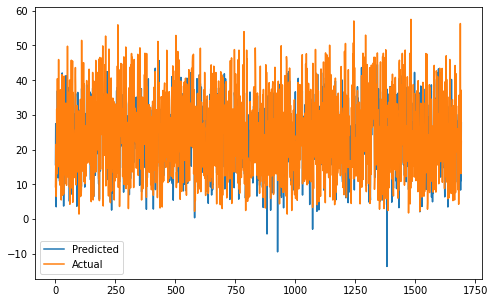

In [ ]:
# plot for test data
plt.figure(figsize=(8,5))
plt.plot(y_pred_lasso_test)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:
model_evaluation_show_and_save(lasso, "Lasso Regression", X_test, y_train, y_test, y_pred_lasso_train, y_pred_lasso_test)

For Train Data: 
MSE  :  54.10708652159317
RMSE  :  7.35575193447911
MAE  :  5.740440109723706
R2  :  0.6168180121955105
Adjusted R2  :  0.614080997996907
----------------------------------------
For Test Data: 
MSE  :  55.391033203865604
RMSE  :  7.442515247136925
MAE  :  5.735024408899926
R2  :  0.598427494075488
Adjusted R2  :  0.5955591190331702


## RIDGE REGRESSION

In [ ]:
ridge= Ridge(alpha=0.0014)
#FIT THE MODEL
ridge.fit(X_train,y_train)
#check the score
print(f"Ridge regression score: {ridge.score(X_train, y_train)}")

Ridge regression score: 0.616818381258305


In [ ]:
y_pred_ridge_train = ridge.predict(X_train)
y_pred_ridge_test = ridge.predict(X_test)

In [ ]:
model_evaluation_show_and_save(ridge, "Ridge Regression", X_test, y_train, y_test, y_pred_ridge_train, y_pred_ridge_test)

For Train Data: 
MSE  :  54.107034408202686
RMSE  :  7.355748392121816
MAE  :  5.740546934545119
R2  :  0.616818381258305
Adjusted R2  :  0.6140813696958644
----------------------------------------
For Test Data: 
MSE  :  55.38835557979301
RMSE  :  7.4423353579231435
MAE  :  5.734992665345672
R2  :  0.5984469062464941
Adjusted R2  :  0.5955786698625405


## DECISION TREE

In [ ]:
decision_regressor = DecisionTreeRegressor()
decision_regressor.fit(X_train, y_train)

#get the X_train and X-test value
y_pred_train_d = decision_regressor.predict(X_train)
y_pred_test_d = decision_regressor.predict(X_test)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


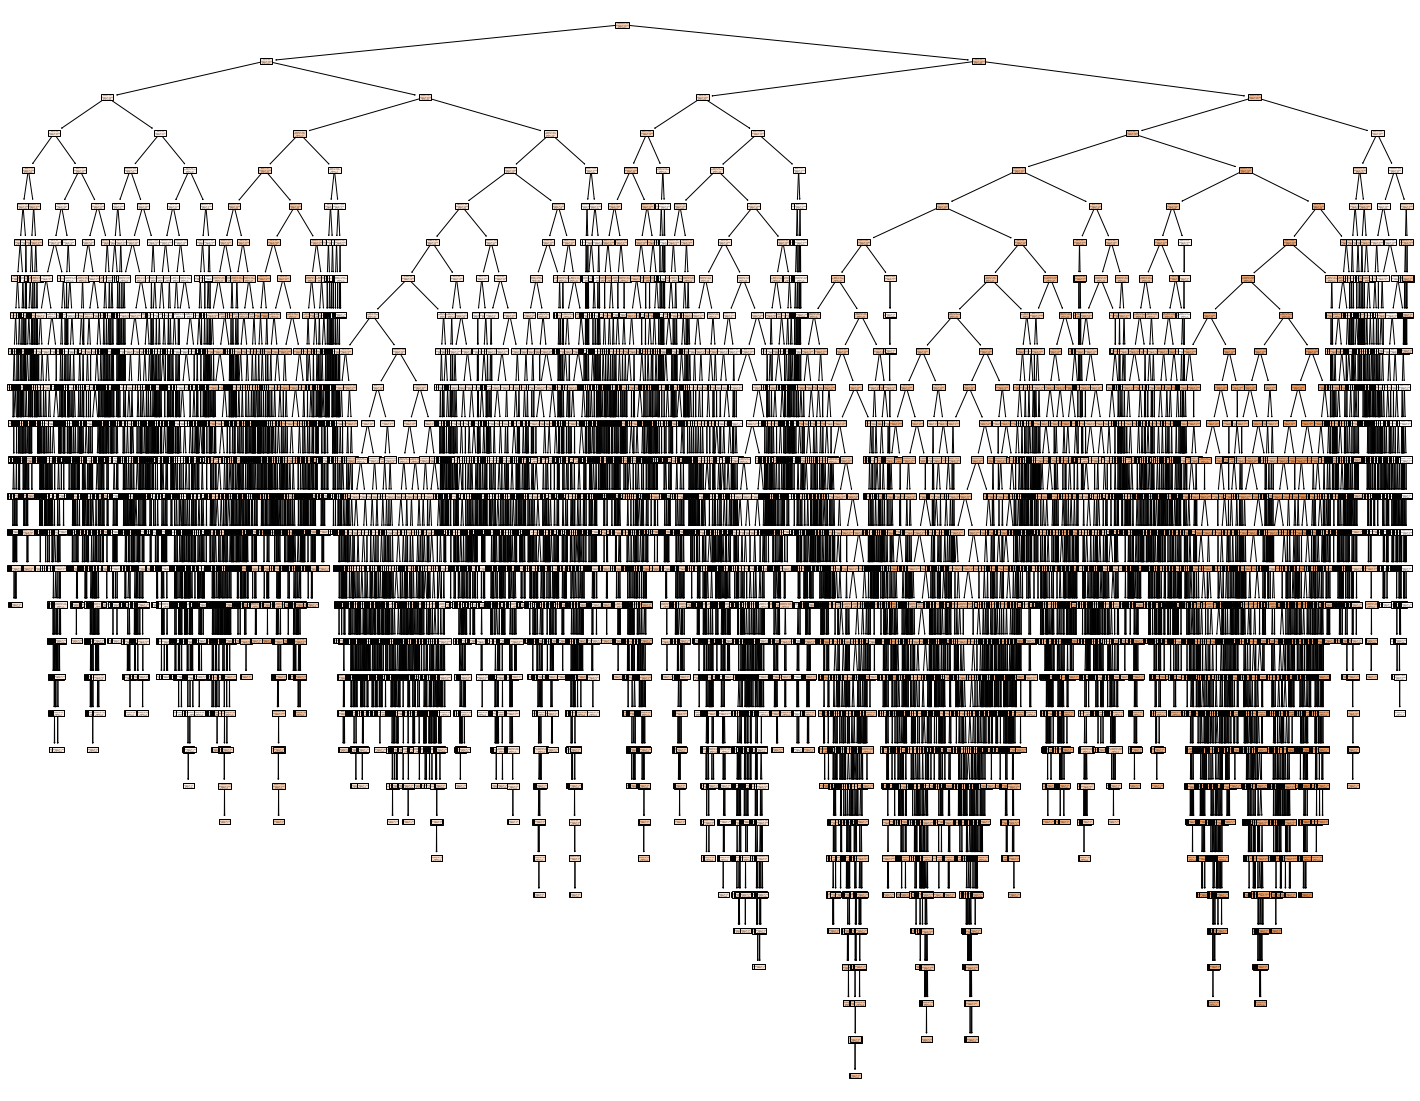

In [ ]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_regressor, 
                   feature_names=feature_columns,  
                   class_names=dependent_variable,
                   filled=True)

In [ ]:
model_evaluation_show_and_save(decision_regressor, "Decision Tree", X_test, y_train, y_test, y_pred_train_d, y_pred_test_d)

For Train Data: 
MSE  :  0.0002070650302717495
RMSE  :  0.014389754350639538
MAE  :  0.0003325794989100185
R2  :  0.9999985335822902
Adjusted R2  :  0.999998523107878
----------------------------------------
For Test Data: 
MSE  :  22.253699863757525
RMSE  :  4.717382734499876
MAE  :  2.8625403689427578
R2  :  0.8386656918369699
Adjusted R2  :  0.8375133039215197


## RANDOM FOREST

In [ ]:
# Create an instance of the RandomForestRegressor
rf_model = RandomForestRegressor()
rf_model.fit(X_train,y_train)

RandomForestRegressor()

In [ ]:
# Making predictions on train and test data
y_pred_train_r = rf_model.predict(X_train)
y_pred_test_r = rf_model.predict(X_test)

In [ ]:
model_evaluation_show_and_save(rf_model, "Random Forest", X_test, y_train, y_test, y_pred_train_r, y_pred_test_r)

For Train Data: 
MSE  :  1.3267407683053913
RMSE  :  1.1518423365658128
MAE  :  0.7312174470916964
R2  :  0.9906041297437512
Adjusted R2  :  0.990537016384778
----------------------------------------
For Test Data: 
MSE  :  11.613644144960146
RMSE  :  3.407879713980549
MAE  :  2.1029315025294806
R2  :  0.9158036975941133
Adjusted R2  :  0.9152022954340713


* **Feature Importance**

In [ ]:
importances = rf_model.feature_importances_

importance_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)

importances = rf_model.feature_importances_
importance_df['Feature Importance'] = round(importance_df['Feature Importance'],2)

In [ ]:
importance_df.sort_values(by=['Feature Importance'],ascending=False)

,Feature,Feature Importance
1,Temperature,0.37
0,Hour,0.31
2,Humidity,0.12
5,Rainfall,0.06
7,Seasons,0.04
10,isWeekend,0.03
4,Solar Radiation,0.02
9,month,0.02
3,Visibility,0.01
8,Holiday,0.01


## GRADIENT BOOSTING

In [ ]:
# Create an instance of the GradientBoostingRegressor
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train,y_train)

GradientBoostingRegressor()

In [ ]:
# Making predictions on train and test data
y_pred_train_g = gb_model.predict(X_train)
y_pred_test_g = gb_model.predict(X_test)

In [ ]:
# custom function
model_evaluation_show_and_save(gb_model, "Gradient Boosting", X_test, y_train, y_test, y_pred_train_g, y_pred_test_g)

For Train Data: 
MSE  :  12.584936549363677
RMSE  :  3.5475254120814523
MAE  :  2.51379420279409
R2  :  0.9108745025209583
Adjusted R2  :  0.9102378918246794
----------------------------------------
For Test Data: 
MSE  :  16.659540052083265
RMSE  :  4.081609982847855
MAE  :  2.8432353762266285
R2  :  0.8792220895818572
Adjusted R2  :  0.8783593902217276


# Selecting Best Model

* **Model scores**

In [ ]:
show_model_scores().T

MSE      RMSE       MAE        R2  Adjusted R2
Train Linear Regression  54.107034  7.355748  5.740547  0.616818     0.614081
      Lasso Regression   54.107087  7.355752  5.740440  0.616818     0.614081
      Ridge Regression   54.107034  7.355748  5.740547  0.616818     0.614081
      Decision Tree       0.000207  0.014390  0.000333  0.999999     0.999999
      Random Forest       1.326741  1.151842  0.731217  0.990604     0.990537
      Gradient Boosting  12.584937  3.547525  2.513794  0.910875     0.910238
Test  Linear Regression  55.388354  7.442335  5.734993  0.598447     0.595579
      Lasso Regression   55.391033  7.442515  5.735024  0.598427     0.595559
      Ridge Regression   55.388356  7.442335  5.734993  0.598447     0.595579
      Decision Tree      22.253700  4.717383  2.862540  0.838666     0.837513
      Random Forest      11.613644  3.407880  2.102932  0.915804     0.915202
      Gradient Boosting  16.659540  4.081610  2.843235  0.879222     0.878359

* **From different models, 'Random Forest' has the highest R2 & Adjusted R2 for testing data. So, we will select this model and find the best hyperparameters for it.**

In [ ]:
# Hyperparameter tuning using RandomizedSearch CV
n_estimators = [5,10,20,50,100,200, 400] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(50, 600, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10, 15, 30] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {
                'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap
              }

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf_model,param_distributions = random_grid,    #
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [ ]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [50, 100, 150, 200, 250,
                                                      300, 350, 400, 450, 500,
                                                      550, 600],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10, 15, 30],
                                        'n_estimators': [5, 10, 20, 50, 100,
                                                         200, 400]},
                   random_state=35, verbose=2)

In [ ]:
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_)

Best Parameters:  {'n_estimators': 400, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 300, 'bootstrap': False}


* **Grid search is used after randomised search to narrow down the range to search the perfect hyperparameters. Now that we know where we can focus we can explicitly run those parameters through grid search and evaluate different models to get the final values for every hyperparameter.**

In [ ]:
# parameters for fine tuning
param_grid = {
      'n_estimators': [380,390,400,410,420],
      'min_samples_split': [4,5,6,7,8,9], 
      'min_samples_leaf': [1,2], 
      'max_features': ['sqrt'], 
      'max_depth': [280,290,300,310,320], 
      'bootstrap': [False]
     }

In [ ]:
# Create a base model
rf = RandomForestRegressor()

In [ ]:
# Hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False],
                         'max_depth': [280, 290, 300, 310, 320],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [4, 5, 6, 7, 8, 9],
                         'n_estimators': [380, 390, 400, 410, 420]},
             verbose=2)

In [ ]:
# get best parameters
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 320,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 410}

In [ ]:
# Create Random Forest with best parameters 
best_rf = RandomForestRegressor(bootstrap=False, max_depth=290, max_features='sqrt',
                      min_samples_split=4, n_estimators=390)

In [ ]:
best_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=290, max_features='sqrt',
                      min_samples_split=4, n_estimators=390)

In [ ]:
y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)

In [ ]:
model_evaluation_show_and_save(best_rf, "Random Forest", X_test, y_train, y_test, y_pred_train, y_pred_test)

For Train Data: 
MSE  :  0.3937936006293233
RMSE  :  0.6275297607518892
MAE  :  0.41532530159763326
R2  :  0.9972111857360197
Adjusted R2  :  0.9971912656341342
----------------------------------------
For Test Data: 
MSE  :  11.238047990312861
RMSE  :  3.3523197923695855
MAE  :  2.1627324212664307
R2  :  0.9185266850582069
Adjusted R2  :  0.9179447328086227


# Explanatory model

* **Using SHAP (SHapley Additive exPlanations)**

In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 4.3 MB/s 


In [ ]:
import shap

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


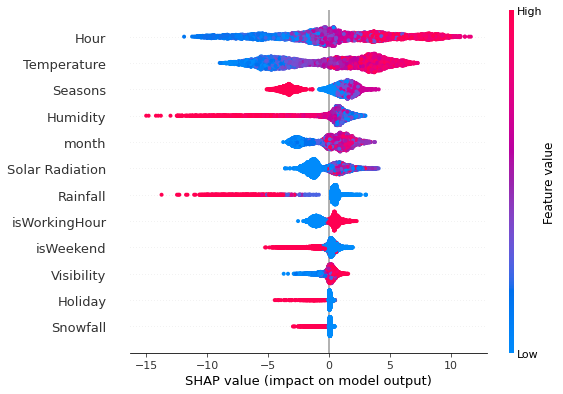

In [ ]:
# Create object that can calculate shap values
explainer_train = shap.TreeExplainer(best_rf)

# calculate shap values. This is what we will plot.
shap_values_train = explainer_train.shap_values(X_train)

# make plot.
shap.summary_plot(shap_values_train,X_train,plot_type='dot')

**From the above diagram:**
* **The features are in descending order of their importance i.e. 'Temperature' has the highest importance and 'Visibility' has the lowest importance.**
* **From the 'Temperature' feature we can see that bike rental decreases with a decrease in temperature.**
* **From the 'Hour' feature, for a low value of 'Hour' bike rental is less than a high value of 'Hour'.**
* **From the 'Humidity' feature, we can say that for high humidity bike rental is less than for low humidity.**

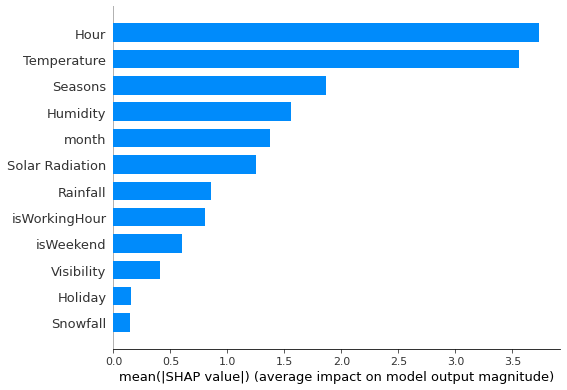

In [ ]:
shap.summary_plot(shap_values_train, X_train, plot_type='bar')

* **The above plot shows the most important features in decreasing order.**

# Conclusion

* **We observed that the bike rental count is high on weekdays than on weekends.**
* **During weekdays at 7-9 AM and 5-7 PM, there are sudden spikes in bike count.**
* **The bike count is high at high temperatures.**
* **In summer the bike count is the highest and in winter it is the lowest.**
* **In summer the bike count is the highest and in winter it is the lowest.
When we compare the RMSE and Adjusted R2 of all the models for test data, Random Forest gives the highest Score where the Adjusted R2 score is 0.91 and RMSE is 3.4. So this model is the best for predicting the bike rental count on hourly basis.**